In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import json
import os
import shutil
import sys
sys.path.append("..")

from PJT_Frustration_Induced_Crystallize.main import *

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
# cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [119]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=0.25, phaseLagA0=0.6 * np.pi,
    speedV=3,
    freqDist="uniform", initPhaseTheta=None,
    omegaMin=0, deltaOmega=0, 
    agentsNum=5000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

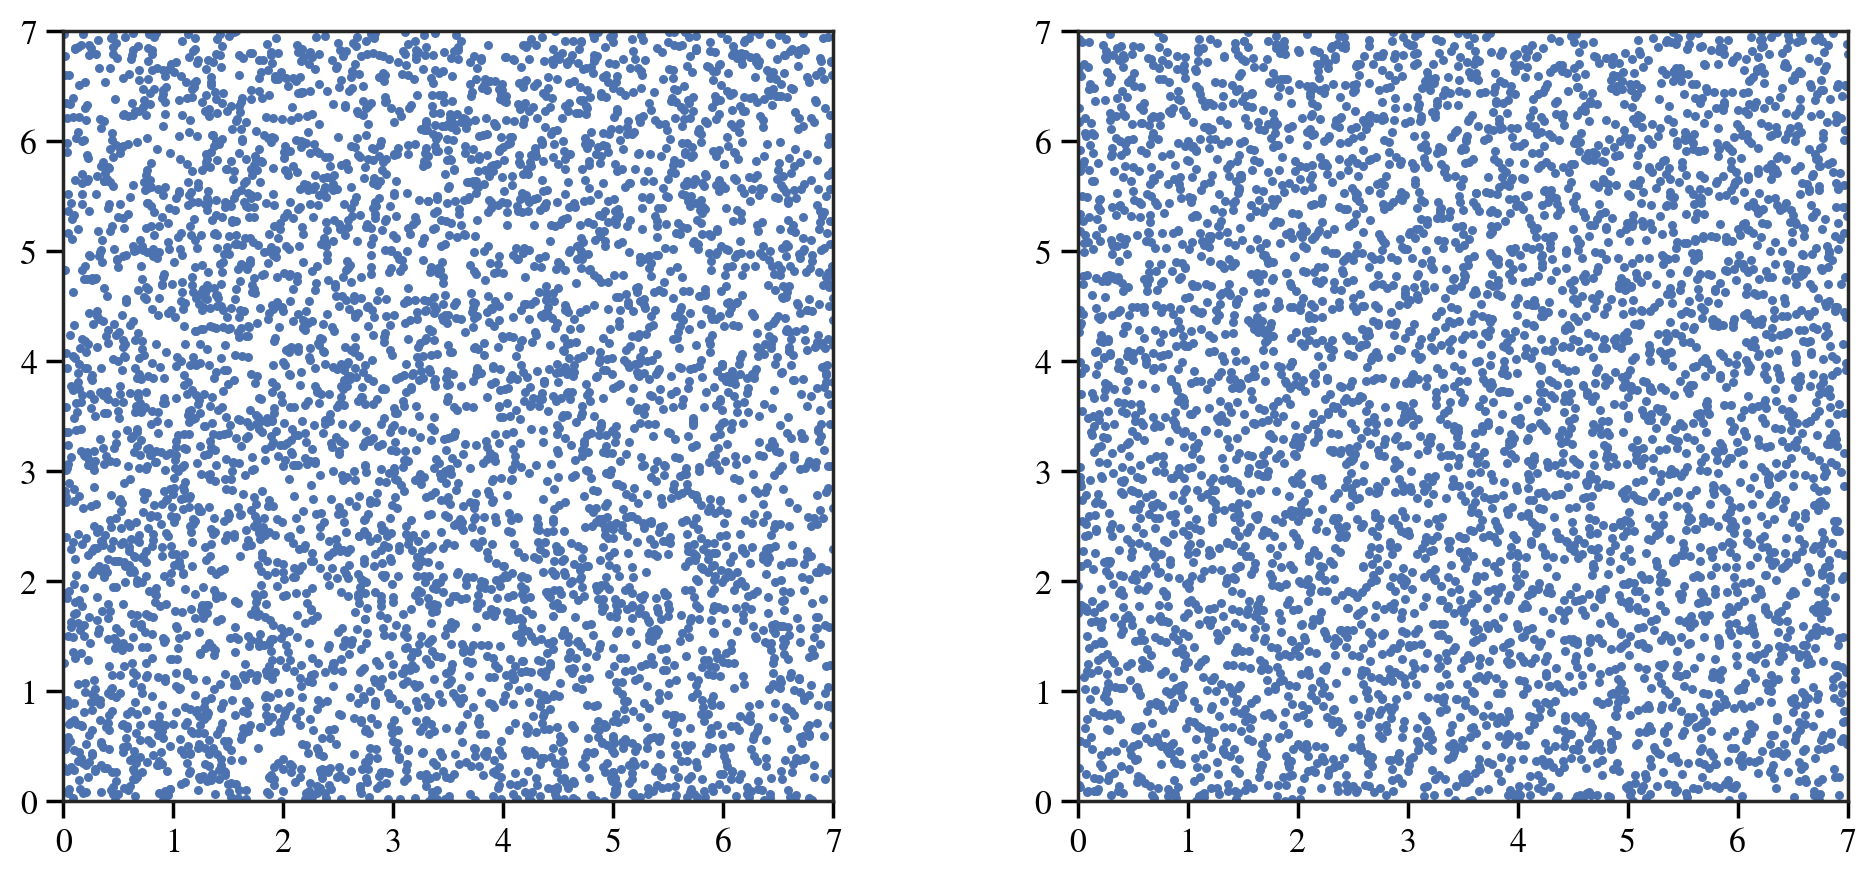

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axs[0]
positionX = sa.model.positionX
ax1.scatter(positionX[:, 0], positionX[:, 1], s=5)
ax1.set_xlim(0, sa.model.boundaryLength)
ax1.set_ylim(0, sa.model.boundaryLength)
ax1.set_aspect("equal")
ax2 = axs[1]
positionX, _ = sa.get_state(541)
ax2.scatter(positionX[:, 0], positionX[:, 1], s=5)
ax2.set_xlim(0, sa.model.boundaryLength)
ax2.set_ylim(0, sa.model.boundaryLength)
ax2.set_aspect("equal")

In [121]:
rs = np.linspace(0, 2, 1000)
Pr = 2*np.pi*rs * np.exp(-np.pi * rs**2)

<Figure size 600x600 with 0 Axes>

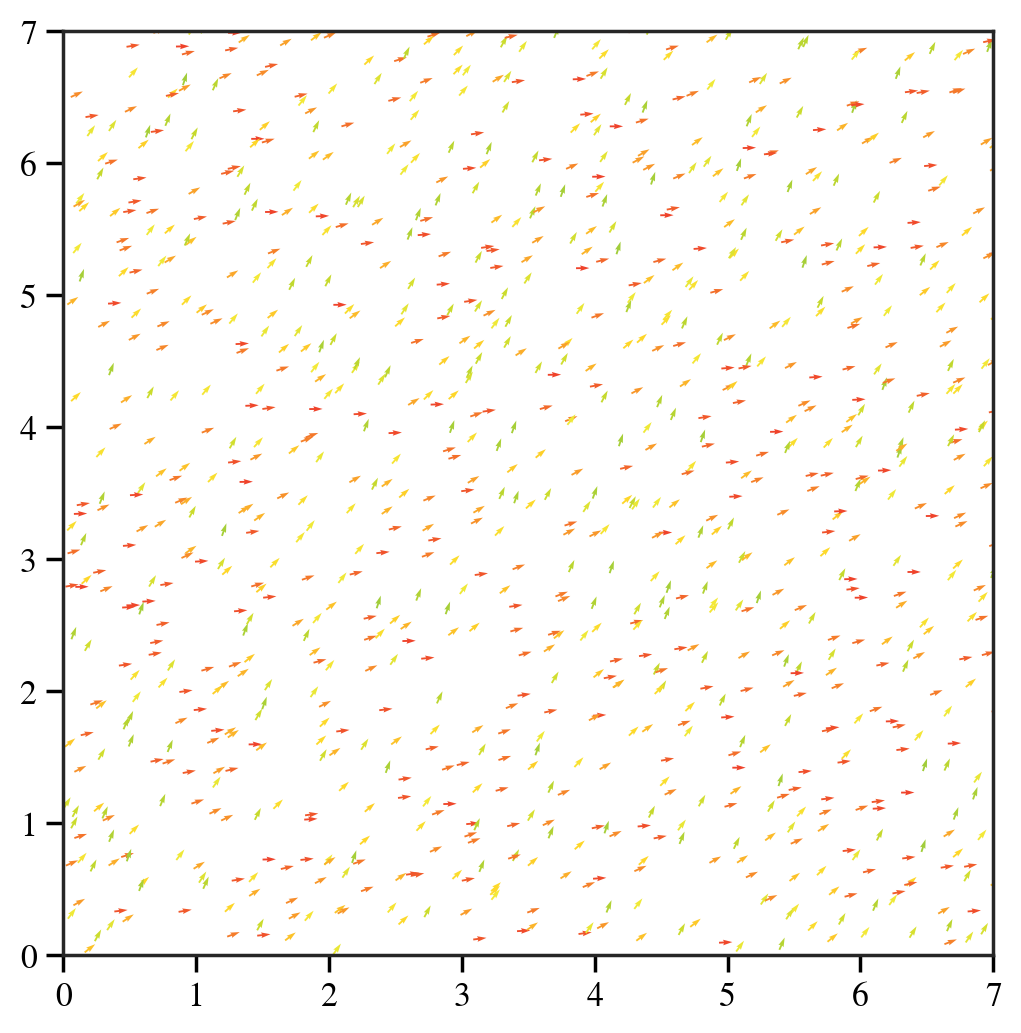

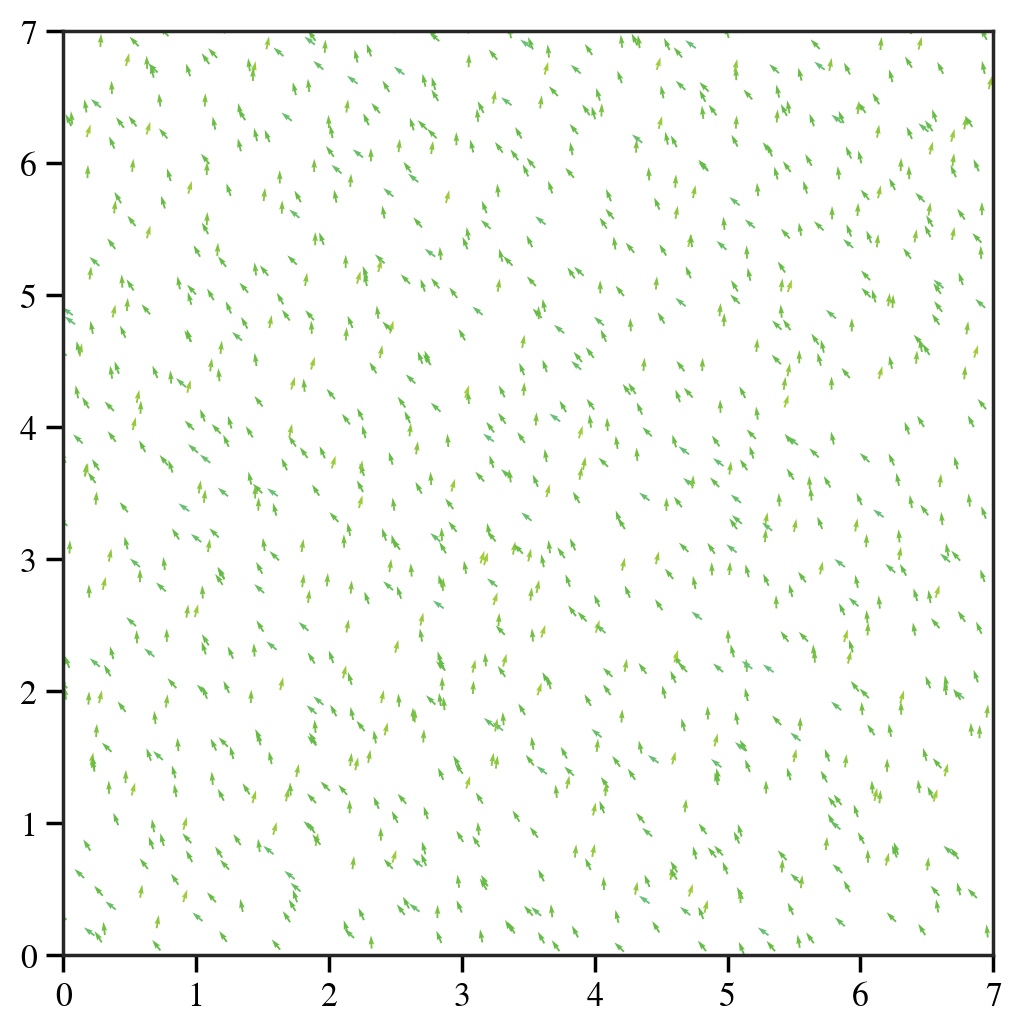

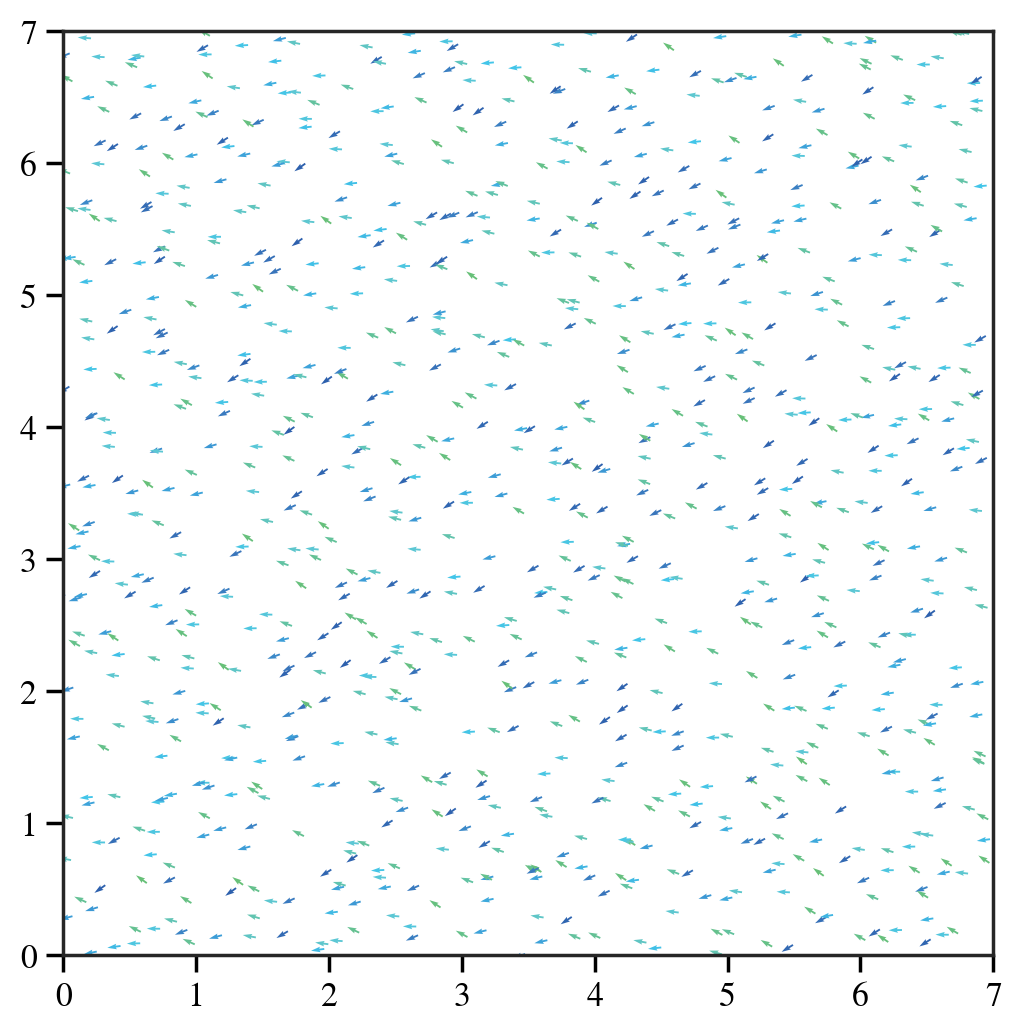

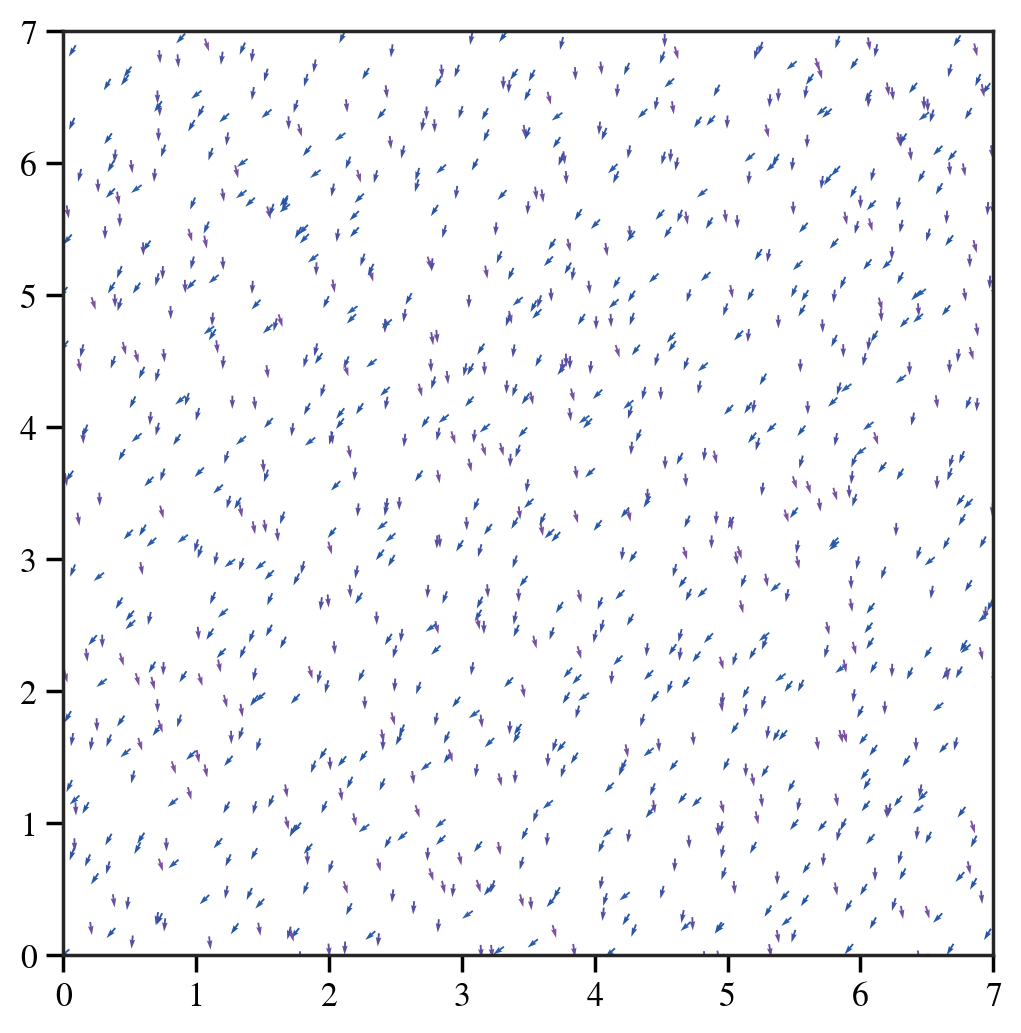

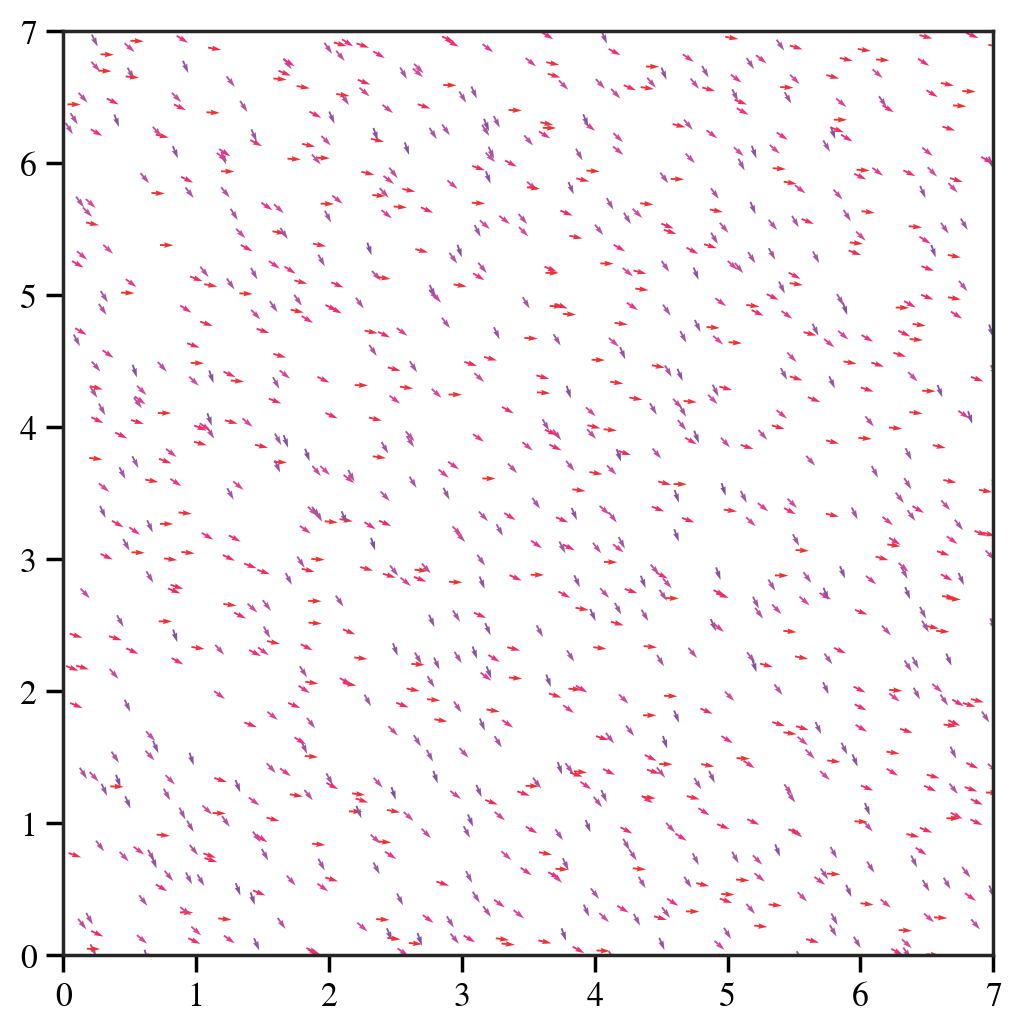

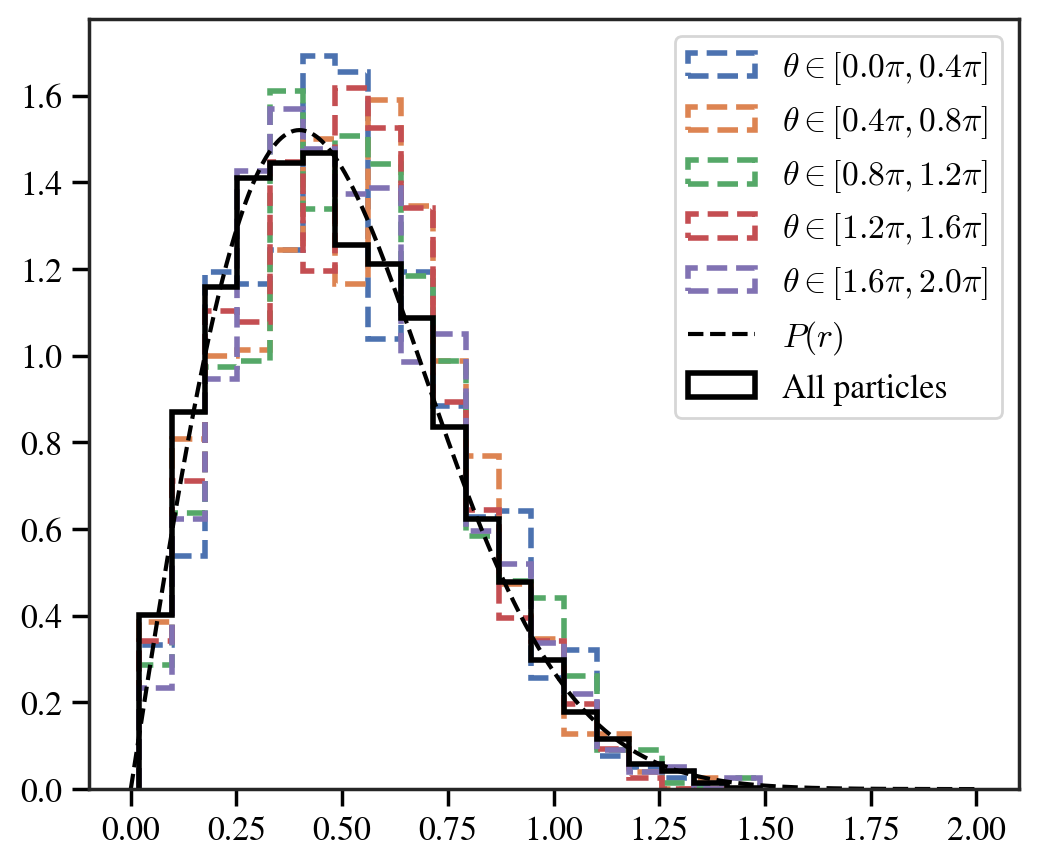

In [122]:
positionX, phaseTheta = sa.get_state(-1)
# positionX, phaseTheta = model.positionX, model.phaseTheta
splitPhaseBin = np.linspace(0, 2 * np.pi, 6)
selectIdxs = np.digitize(phaseTheta, splitPhaseBin) - 1
selectIdxs = [
    np.where(selectIdxs == i)[0] for i in range(len(splitPhaseBin) - 1)
]
dsFDict = {}
subPositionXs = {
    "All particles": sa.totalPositionX
}
initSubPPositionXs = {
    "All particles": model.positionX
}

plt.figure(figsize=(6, 6))
for i, idxs in enumerate(selectIdxs):
    key = r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi)
    subPositionX = positionX[idxs]
    subPhaseTheta = phaseTheta[idxs]
    subPositionXs[key] = sa.totalPositionX[:, idxs]
    initSubPPositionXs[key] = model.positionX[idxs]
    colors = [hexCmap(i) for i in
        np.floor(256 - subPhaseTheta / (2 * np.pi) * 256).astype(np.int32)
    ]
    plt.figure(figsize=(6, 6))
    plt.quiver(
        subPositionX[:, 0], subPositionX[:, 1],
        np.cos(subPhaseTheta), np.sin(subPhaseTheta),
        scale_units='inches', scale=15.0, width=0.002,
        color=colors
    )
    # plt.scatter(
    #     subPositionX[:, 0], subPositionX[:, 1],
    #     s=5
    # )
    plt.xlim(0, sa.model.boundaryLength)
    plt.ylim(0, sa.model.boundaryLength)
    plt.show()

    r0 = sa.model.boundaryLength / np.sqrt(subPositionX.shape[0])
    dsF = sa.calc_replative_distance(subPositionX, subPositionX[:, np.newaxis])
    dsF[dsF == 0] = np.inf
    dsF = dsF.min(axis=0) / r0

    dsFDict[i] = dsF

# plt.show()

all_data = np.concatenate(list(dsFDict.values()) + [dsF])
min_val, max_val = np.min(all_data), np.max(all_data)

bins = np.linspace(min_val, max_val, 20)

for i, dsF in dsFDict.items():
    plt.hist(dsF, density=True, bins=bins, histtype='step', lw=2, ls="--",
             label=r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi))

plt.plot(rs, Pr, color="black", linewidth=1.5, label="$P(r)$", ls="--")

r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
dsF = sa.calc_replative_distance(sa.totalPositionX[-1], sa.totalPositionX[-1][:, np.newaxis])
dsF[dsF == 0] = np.inf
dsF = dsF.min(axis=0) / r0
plt.hist(dsF, density=True, bins=bins, alpha=1, color="black", histtype='step', lw=2, label="All particles")
plt.legend()

<Figure size 600x600 with 0 Axes>

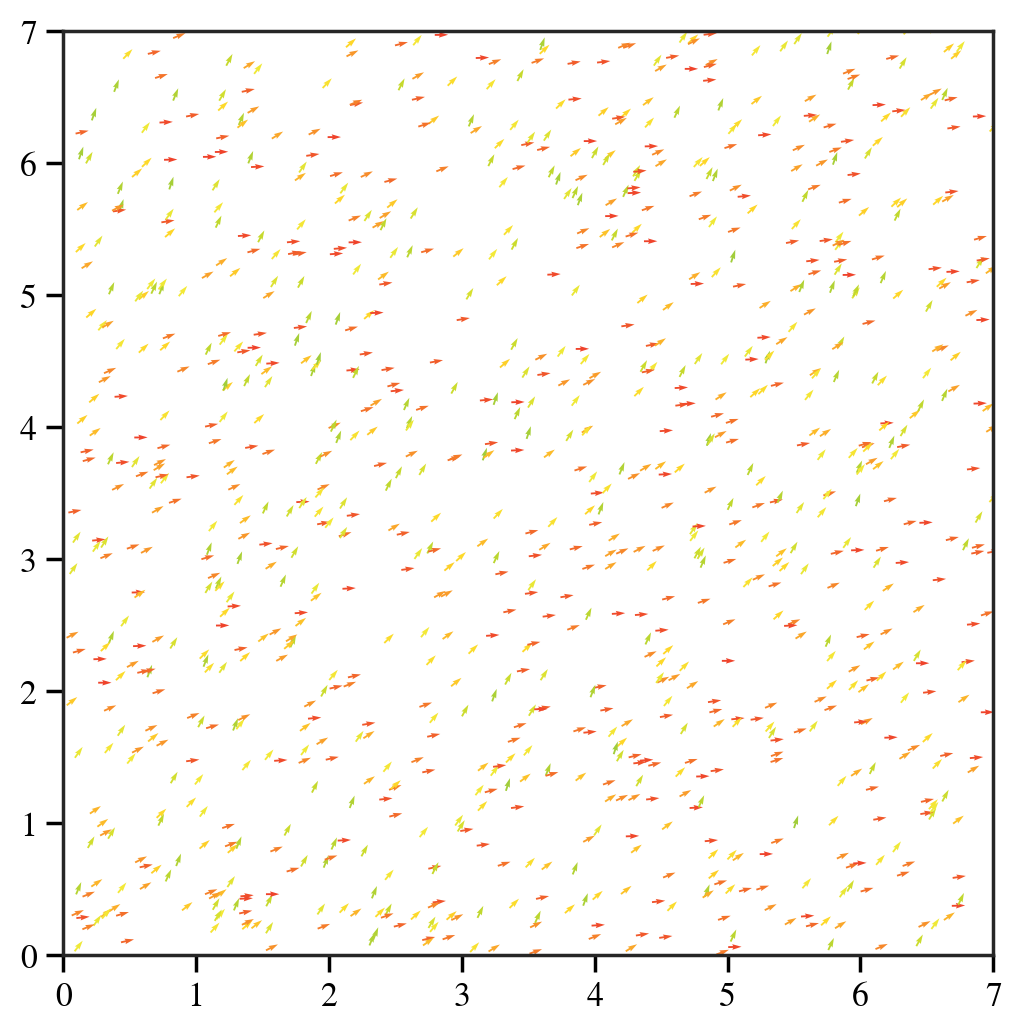

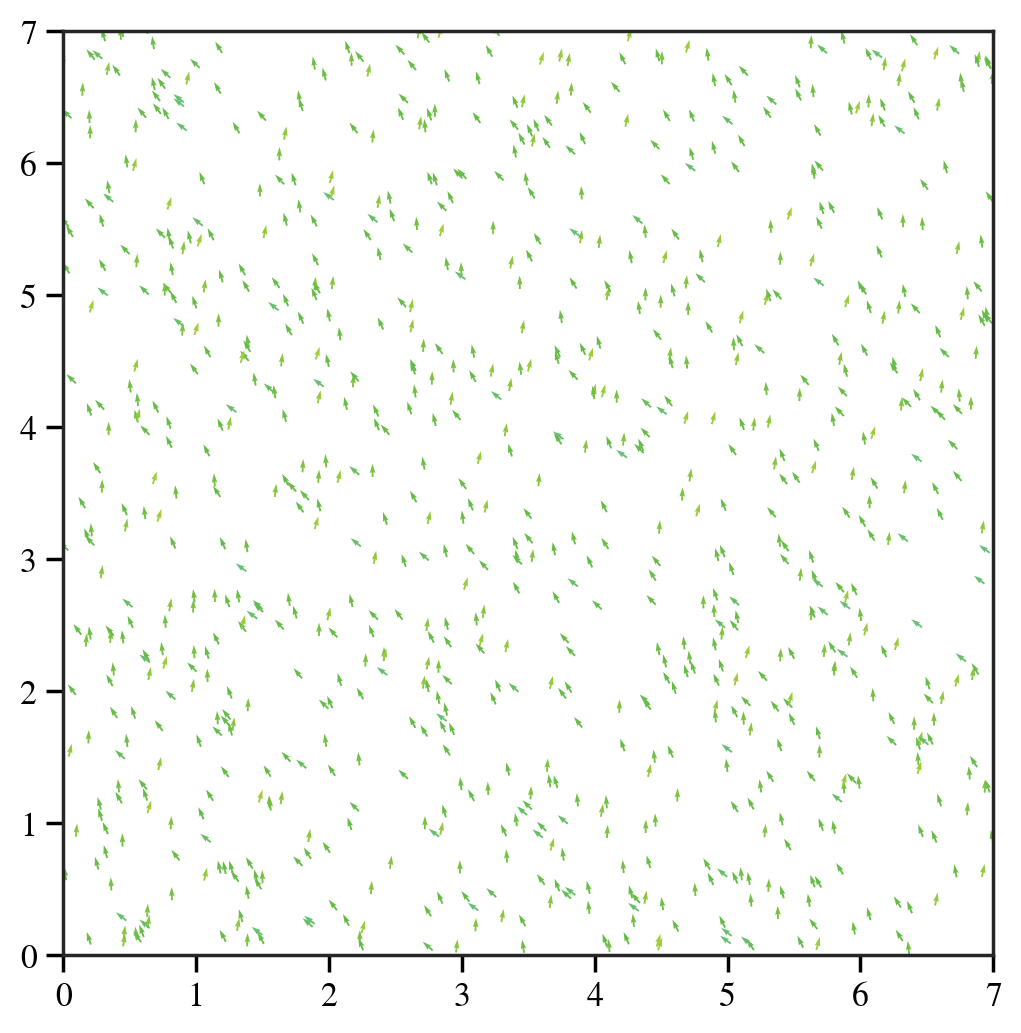

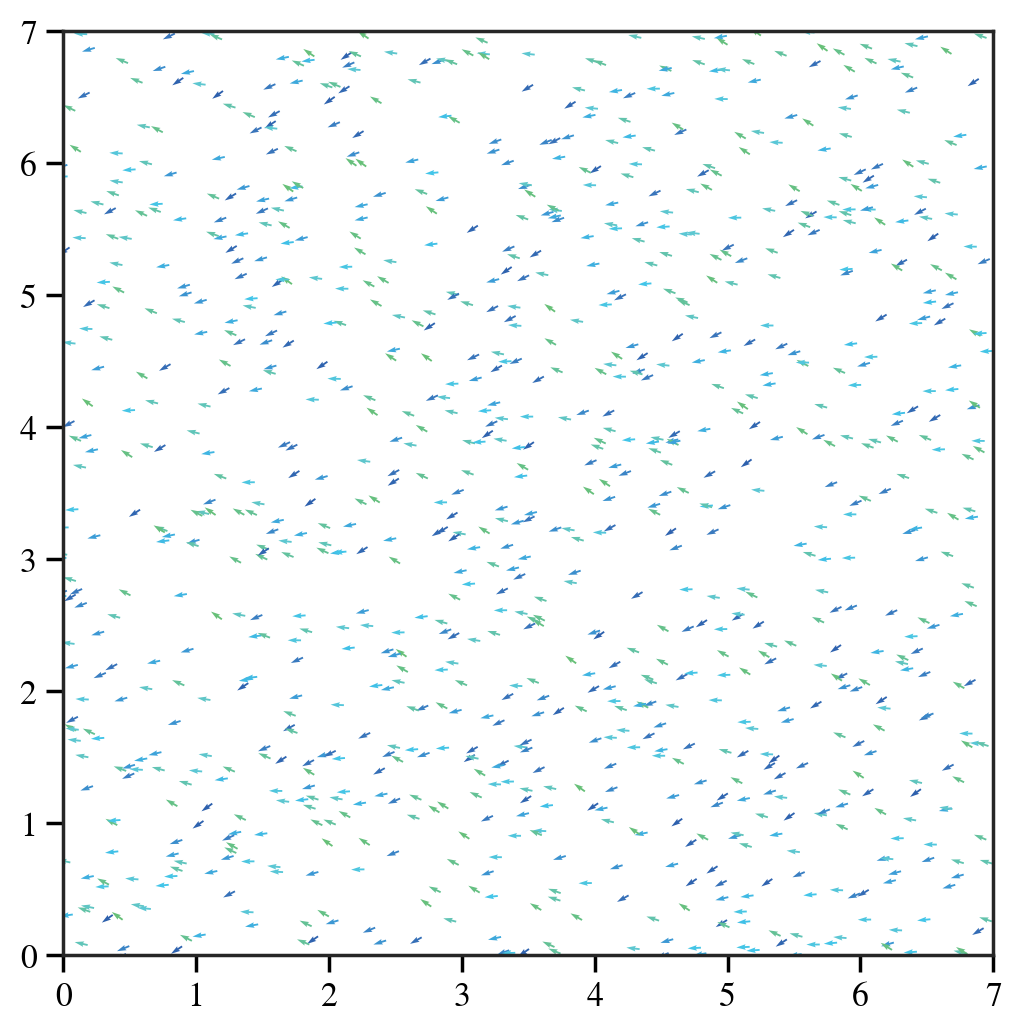

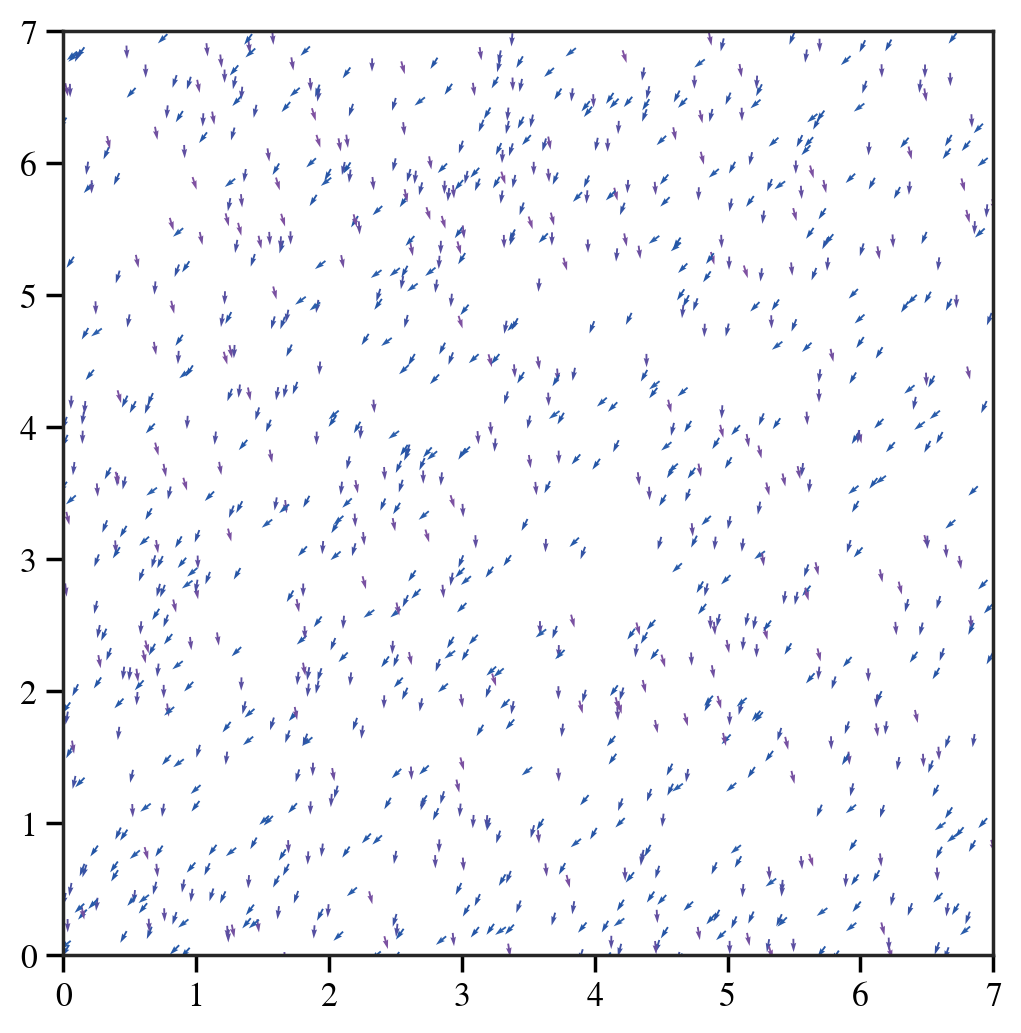

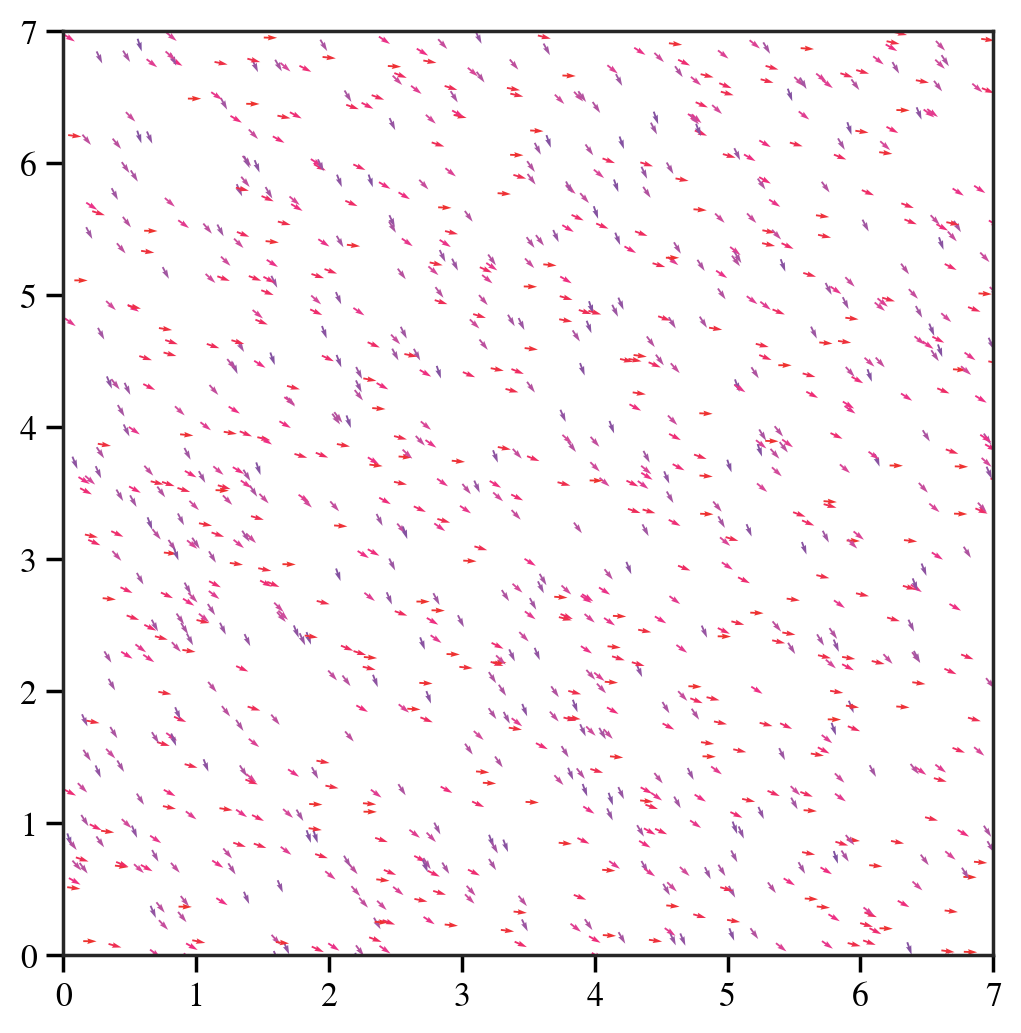

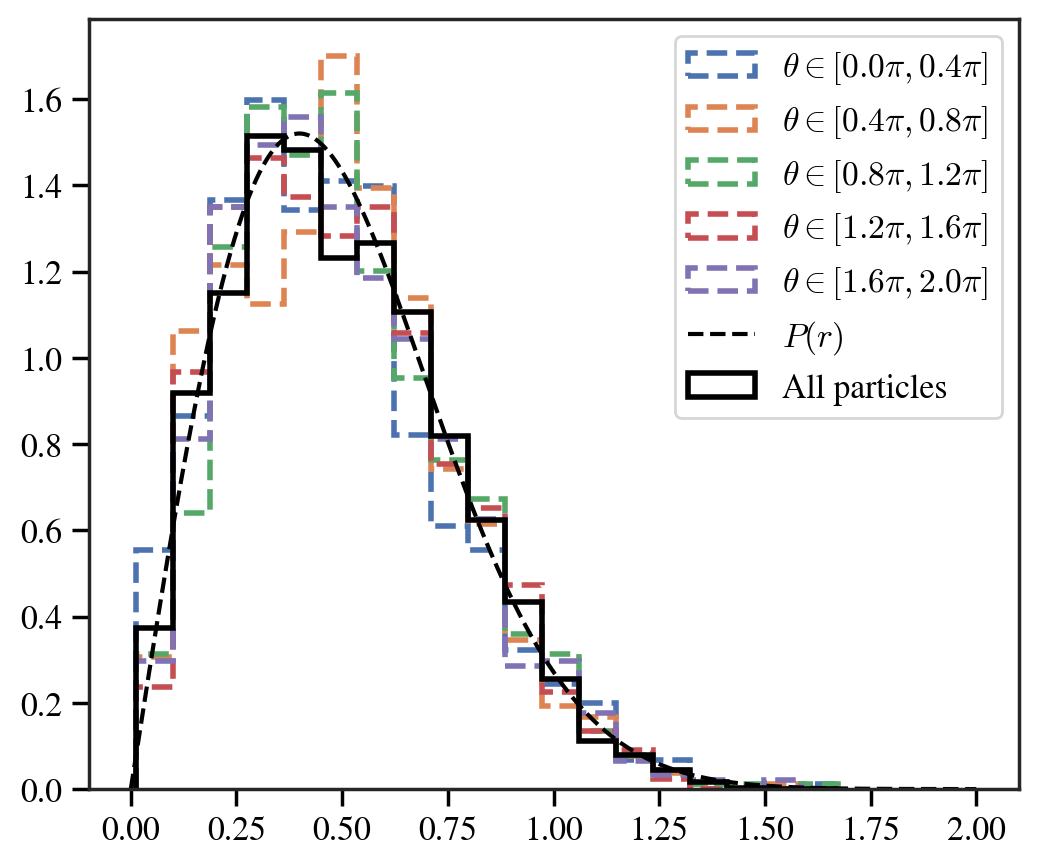

In [123]:
# positionX, phaseTheta = sa.get_state(-1)
positionX, phaseTheta = model.positionX, model.phaseTheta
splitPhaseBin = np.linspace(0, 2 * np.pi, 6)
selectIdxs = np.digitize(phaseTheta, splitPhaseBin) - 1
selectIdxs = [
    np.where(selectIdxs == i)[0] for i in range(len(splitPhaseBin) - 1)
]
dsFDict = {}
subPositionXs = {
    "All particles": sa.totalPositionX
}
initSubPPositionXs = {
    "All particles": model.positionX
}

plt.figure(figsize=(6, 6))
for i, idxs in enumerate(selectIdxs):
    key = r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi)
    subPositionX = positionX[idxs]
    subPhaseTheta = phaseTheta[idxs]
    subPositionXs[key] = sa.totalPositionX[:, idxs]
    initSubPPositionXs[key] = model.positionX[idxs]
    colors = [hexCmap(i) for i in
        np.floor(256 - subPhaseTheta / (2 * np.pi) * 256).astype(np.int32)
    ]
    plt.figure(figsize=(6, 6))
    plt.quiver(
        subPositionX[:, 0], subPositionX[:, 1],
        np.cos(subPhaseTheta), np.sin(subPhaseTheta),
        scale_units='inches', scale=15.0, width=0.002,
        color=colors
    )
    # plt.scatter(
    #     subPositionX[:, 0], subPositionX[:, 1],
    #     s=5
    # )
    plt.xlim(0, sa.model.boundaryLength)
    plt.ylim(0, sa.model.boundaryLength)
    plt.show()

    r0 = sa.model.boundaryLength / np.sqrt(subPositionX.shape[0])
    dsF = sa.calc_replative_distance(subPositionX, subPositionX[:, np.newaxis])
    dsF[dsF == 0] = np.inf
    dsF = dsF.min(axis=0) / r0

    dsFDict[i] = dsF

# plt.show()

all_data = np.concatenate(list(dsFDict.values()) + [dsF])
min_val, max_val = np.min(all_data), np.max(all_data)

bins = np.linspace(min_val, max_val, 20)

for i, dsF in dsFDict.items():
    plt.hist(dsF, density=True, bins=bins, histtype='step', lw=2, ls="--",
             label=r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi))

plt.plot(rs, Pr, color="black", linewidth=1.5, label="$P(r)$", ls="--")

r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
dsF = sa.calc_replative_distance(sa.totalPositionX[-1], sa.totalPositionX[-1][:, np.newaxis])
dsF[dsF == 0] = np.inf
dsF = dsF.min(axis=0) / r0
plt.hist(dsF, density=True, bins=bins, alpha=1, color="black", histtype='step', lw=2, label="All particles")
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

@nb.njit
def calculate_Sk_continuous(positions, k_vec):
    N = len(positions)
    phases = np.exp(-1j * np.dot(positions, k_vec))
    sum_phase = np.sum(phases)
    return np.abs(sum_phase)**2 / N

@nb.njit(parallel=True)
def compute_S_radial_parallel(totalPositions_cont, k_values, k_vectors, num_angles):
    num_time_steps = len(totalPositions_cont)
    num_k_points = len(k_values)
    S_radial = np.zeros((num_k_points, num_time_steps))
    
    for t in nb.prange(num_time_steps):
        positions = totalPositions_cont[t]
        for i in range(num_k_points):
            k_mag = k_values[i]
            S_angle_avg = 0.0
            for j in range(len(k_vectors)):
                k_vec = k_mag * k_vectors[j]
                S_k = calculate_Sk_continuous(positions, k_vec)
                S_angle_avg += S_k
            S_radial[i, t] = S_angle_avg / num_angles
    return S_radial

# 参数设置
k_max = 10.0  # 最大k值
num_k_points = 100
num_angles = 72  # 角度采样数（越多越准确）

# 预计算k值和角度向量
k_values = np.linspace(0, k_max, num_k_points + 1)[1:]
angles = np.linspace(0, 2*np.pi, num_angles, endpoint=False)
k_vectors = np.ascontiguousarray(np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in angles]))

S_radials = dict()

for key, totalPositions in tqdm(subPositionXs.items()):
    # 确保所有数组都是连续的
    totalPositions_cont = [np.ascontiguousarray(pos[::10]) for pos in totalPositions[541:]]
    
    # 使用Numba加速的计算函数
    S_radial = compute_S_radial_parallel(totalPositions_cont, k_values, k_vectors, num_angles)
    
    S_radials[key] = S_radial.mean(axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import pickle

with open("S_radials.pkl", "wb") as f:
    pickle.dump(S_radials, f)

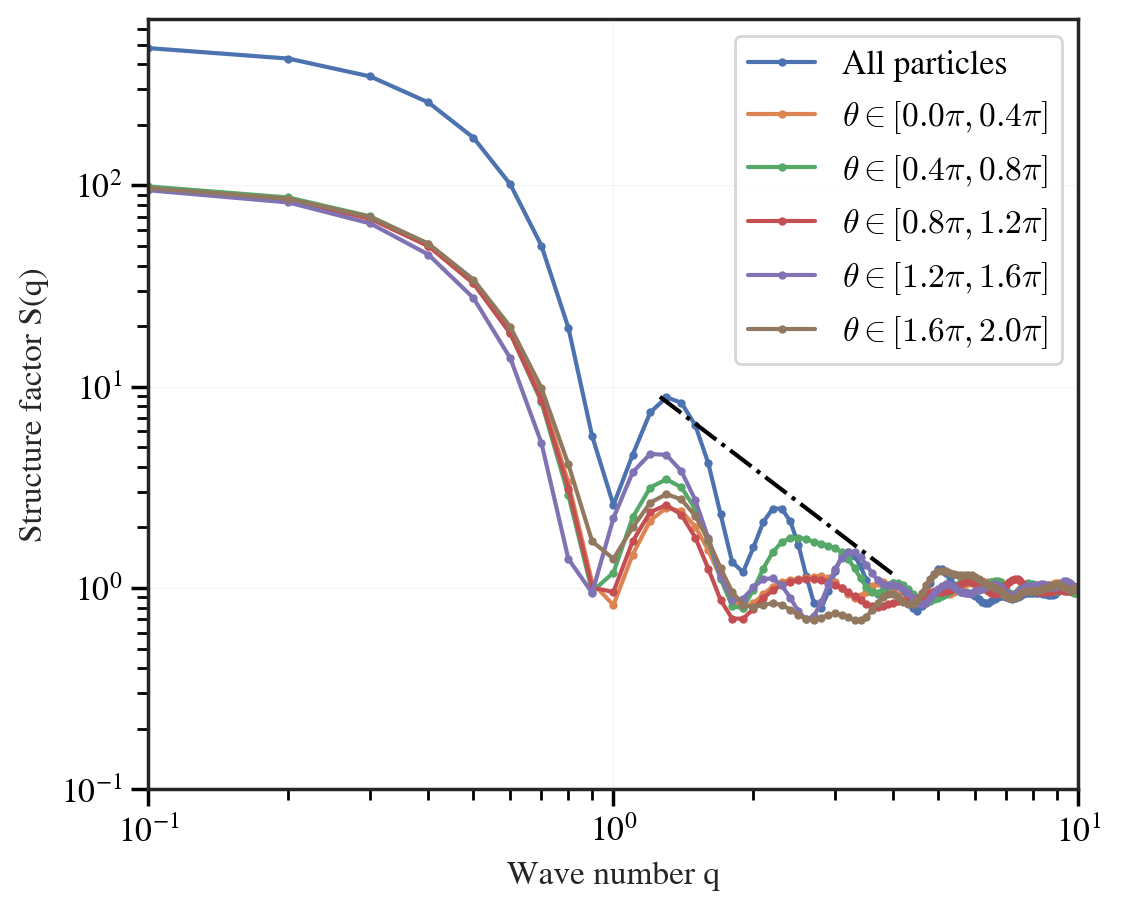

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

for key, S_radial in S_radials.items():

    ax.plot(k_values, S_radial, 'o-', markersize=2, linewidth=1.5, label=key)

# q_theory = np.linspace(0, k_max, 100)
# S_q_squared = q_theory**(1/2)
# ax.plot(q_theory, S_q_squared, '--', color='black', linewidth=1)
subAx = plt.gca()
# startX, startY, xRange, k = 0.75, 0.08, 0.2, 0.25
# subAx.plot([startX, startX + xRange], [startY, startY + xRange * k], 
#            '--', transform=ax.transAxes, color="black")

# q_theory = np.linspace(0, k_max + 2, 100) 
# S_q_squared = q_theory**(-2)
# ax.plot(q_theory, S_q_squared, '--', color='black', linewidth=1)
startX, startY, xRange, k = 0.55, 0.51, 0.25, -0.92
subAx.plot([startX, startX + xRange], [startY, startY + xRange * k], 
           "-.", transform=ax.transAxes, color="black")

ax.semilogx()
ax.semilogy()
ax.set_xlabel('Wave number q', fontsize=12)
ax.set_ylabel('Structure factor S(q)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(0.1, k_max)
ax.set_ylim(0.1, None)

# # 插入小k区域的放大图
# if len(k_values) > 10:
#     inset_idx = min(15, len(k_values))
#     inset_x = k_values[:inset_idx]
#     inset_y = S_radial[:inset_idx]
    
#     ax_inset = plt.axes([0.25, 0.5, 0.3, 0.3])
#     ax_inset.plot(inset_x, inset_y, 'o-', markersize=3)
#     ax_inset.set_xlabel('k')
#     ax_inset.set_ylabel('S(k)')
#     ax_inset.set_title('Small k region')
#     ax_inset.grid(True, alpha=0.3)

# plt.semilogx()
# plt.semilogy()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

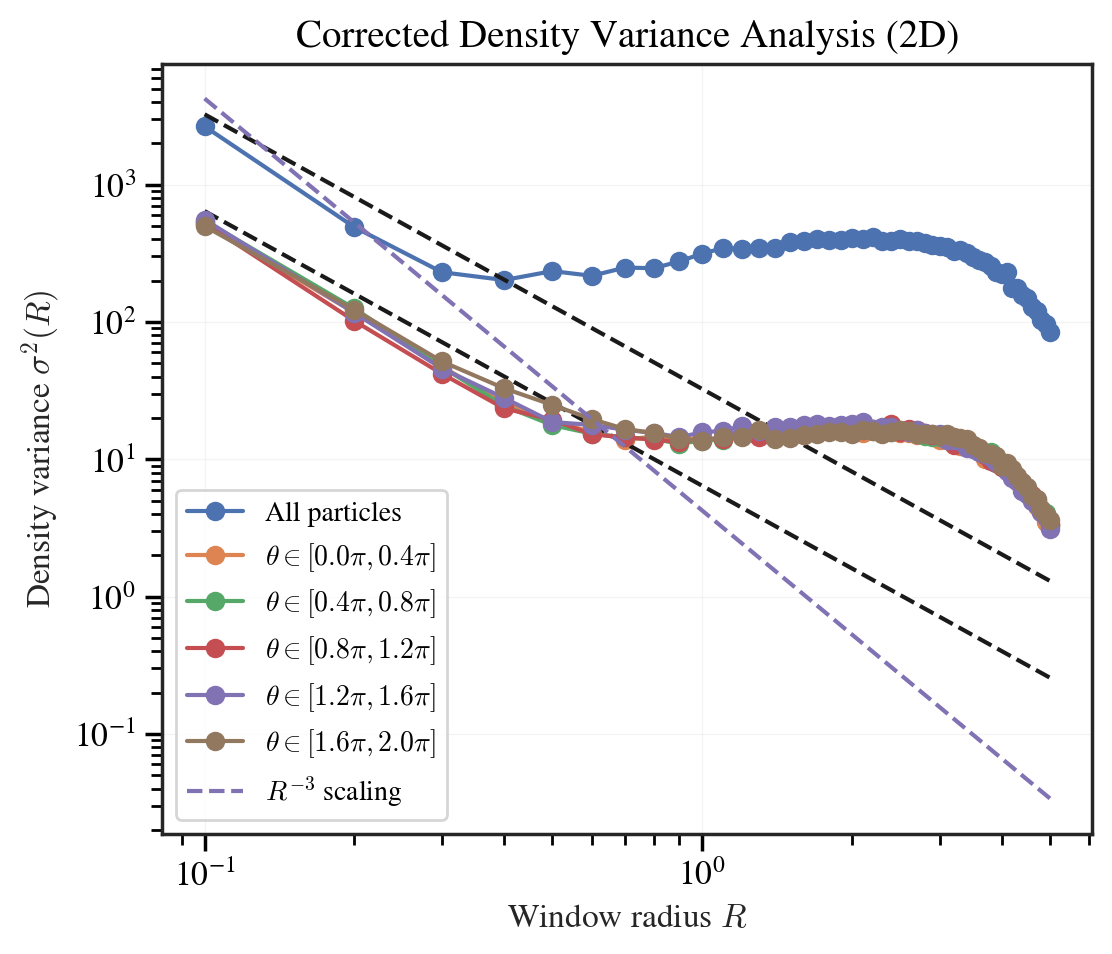

In [ ]:
import numpy as np
from scipy.spatial import distance

def calculate_density_variance_corrected(positions, R_values, box_size: float, num_samples=1000):
    """
    修正后的密度方差计算（σ²(R)随R增大而下降）
    
    参数:
    positions: (N, 2) 或 (N, 3) 数组
    R_values: 窗口半径列表
    num_samples: 每个半径的采样次数
    box_size: 系统尺寸
    
    返回:
    R_values: 半径数组
    sigma_sq: 密度方差 σ²(R)
    poisson_ref: 泊松参考值
    """
    N = len(positions)
    dim = positions.shape[1]
    
    rho0 = N / box_size**2
    
    sigma_sq = []
    poisson_ref = []
    
    for R in R_values:
        density_fluctuations = []
        
        V_R = np.pi * R**2
        
        # 蒙特卡洛采样
        for _ in range(num_samples):
            center = np.random.rand(dim) * box_size
            dists = distance.cdist([center], positions)[0]
            N_R = np.sum(dists <= R)
            
            # 密度涨落 = (局部密度 - 平均密度)
            delta_rho = (N_R / V_R) - rho0
            density_fluctuations.append(delta_rho)
        
        # 计算方差
        sigma_sq.append(np.var(density_fluctuations))
        
        # 泊松参考值 (σ² = ρ0 / V(R))
        poisson_ref.append(rho0 / V_R)
    
    return np.array(R_values), np.array(sigma_sq), np.array(poisson_ref)

R_min = 0.1
R_max = 5.0
num_R = 50
R_values = np.linspace(R_min, R_max, num_R)
subRef = True

for key, totalPositions in tqdm(subPositionXs.items()):
    positions = totalPositions[-1]

    R_values, sigma_sq, poisson_ref = calculate_density_variance_corrected(
        positions, R_values, box_size=model.boundaryLength, num_samples=1000
    )

    plt.loglog(R_values, sigma_sq, 'o-', label=key)

    if subRef or (key == "All particles"):
        plt.loglog(R_values, poisson_ref, 'k--')
        if key != "All particles":
            subRef = False

exponent_3_ref = sigma_sq[5] * (R_values[5]/R_values)**3
plt.loglog(R_values, exponent_3_ref, 'm--', label='$R^{-3}$ scaling')

plt.xlabel('Window radius $R$', fontsize=12)
plt.ylabel(r'Density variance $\sigma^2(R)$', fontsize=12)
plt.title('Corrected Density Variance Analysis (2D)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

  0%|          | 0/6 [00:00<?, ?it/s]

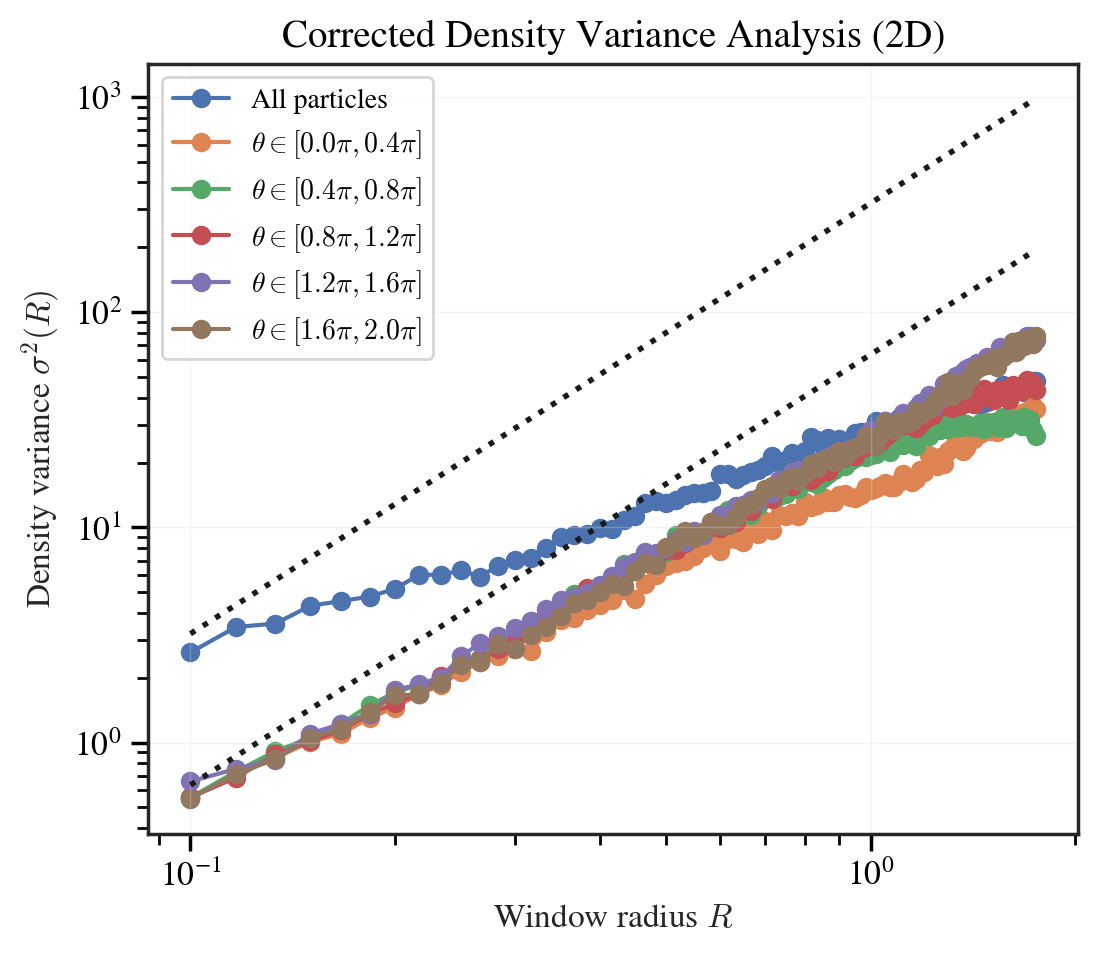

In [ ]:
import numpy as np

def calculate_density_variance_2d(positions, R_values, num_samples=1000, L=10.0):
    """专门针对2D系统的密度方差计算"""
    N = len(positions)
    rho = N / (L * L)  # 平均面密度
    
    variances = []
    poisson_var = []
    
    for R in R_values:
        counts = []
        
        # 蒙特卡洛采样
        for _ in range(num_samples):
            # 随机选择窗口中心（考虑边界效应）
            center = np.random.rand(2) * L
            
            # 计算圆形窗口内的粒子数
            dists = sa.calc_replative_distance(positions, center)
            count = np.sum(dists <= R)
            counts.append(count)
        
        counts = np.array(counts)
        variance = np.var(counts)
        variances.append(variance)
        
        # 泊松参考方差
        window_area = np.pi * R**2
        poisson_var.append(rho * window_area)
    
    return np.array(R_values), np.array(variances), np.array(poisson_var)

R_min = 0.1
R_max = model.boundaryLength / 4
num_R = 100
R_values = np.linspace(R_min, R_max, num_R)
subRef = True

for key, totalPositions in tqdm(subPositionXs.items()):
    positions = totalPositions[541]

    R_values, variances, poisson_var = calculate_density_variance_2d(
        positions, R_values, num_samples=1000, L=model.boundaryLength
    )

    plt.loglog(R_values, variances, 'o-', label=key, zorder=0)

    if subRef or (key == "All particles"):
        plt.plot(R_values, poisson_var, 'k:', linewidth=2, zorder=100)
        if key != "All particles":
            subRef = False

plt.xlabel('Window radius $R$', fontsize=12)
plt.ylabel(r'Density variance $\sigma^2(R)$', fontsize=12)
plt.title('Corrected Density Variance Analysis (2D)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

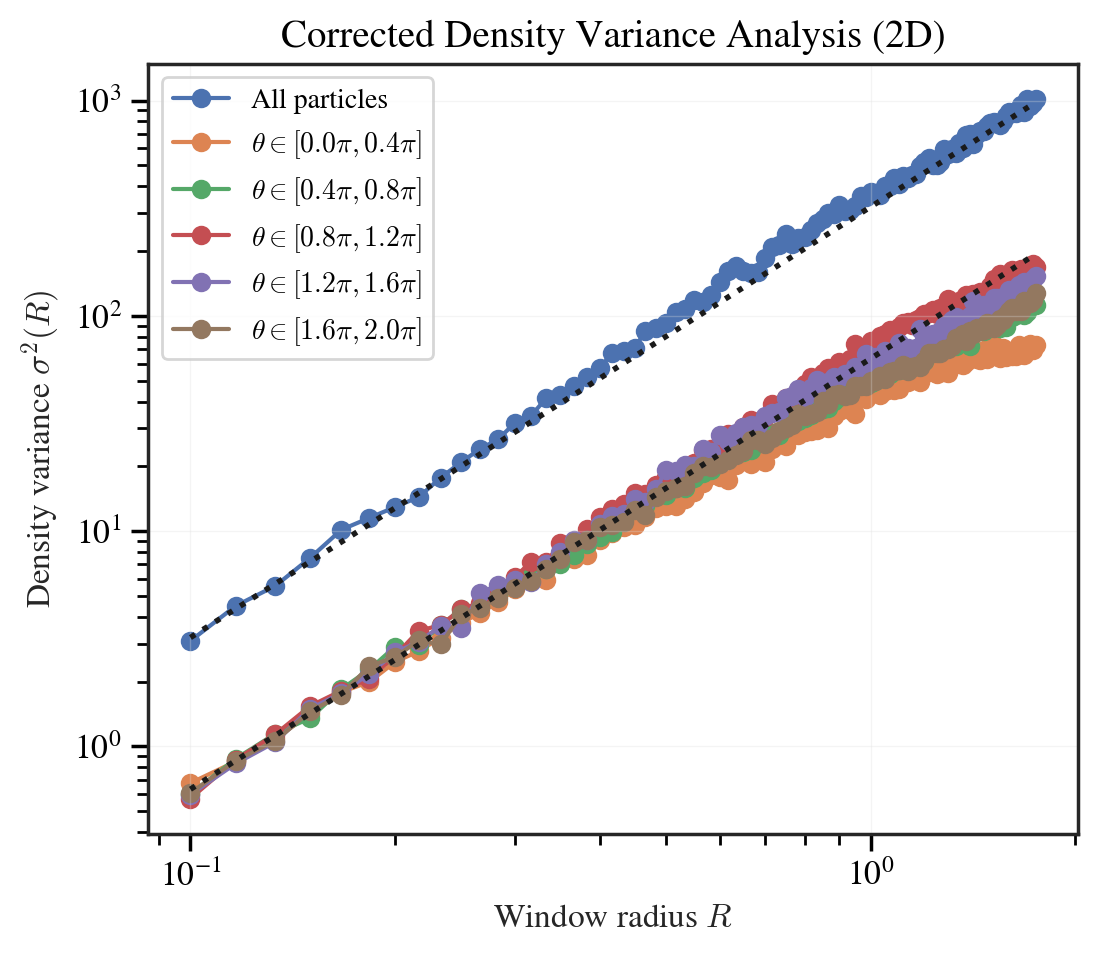

In [ ]:
import numpy as np

def calculate_density_variance_2d(positions, R_values, num_samples=1000, L=10.0):
    """专门针对2D系统的密度方差计算"""
    N = len(positions)
    rho = N / (L * L)  # 平均面密度
    
    variances = []
    poisson_var = []
    
    for R in R_values:
        counts = []
        
        # 蒙特卡洛采样
        for _ in range(num_samples):
            # 随机选择窗口中心（考虑边界效应）
            center = np.random.rand(2) * L
            
            # 计算圆形窗口内的粒子数
            dists = sa.calc_replative_distance(positions, center)
            count = np.sum(dists <= R)
            counts.append(count)
        
        counts = np.array(counts)
        variance = np.var(counts)
        variances.append(variance)
        
        # 泊松参考方差
        window_area = np.pi * R**2
        poisson_var.append(rho * window_area)
    
    return np.array(R_values), np.array(variances), np.array(poisson_var)

R_min = 0.1
R_max = model.boundaryLength / 4
num_R = 100
R_values = np.linspace(R_min, R_max, num_R)
subRef = True

for key, positions in tqdm(initSubPPositionXs.items()):

    R_values, variances, poisson_var = calculate_density_variance_2d(
        positions, R_values, num_samples=1000, L=model.boundaryLength
    )

    plt.loglog(R_values, variances, 'o-', label=key, zorder=0)

    if subRef or (key == "All particles"):
        plt.plot(R_values, poisson_var, 'k:', linewidth=2, zorder=100)
        if key != "All particles":
            subRef = False

plt.xlabel('Window radius $R$', fontsize=12)
plt.ylabel(r'Density variance $\sigma^2(R)$', fontsize=12)
plt.title('Corrected Density Variance Analysis (2D)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

In [2]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=0.25, phaseLagA0=0.6 * np.pi,
    speedV=3,
    freqDist="uniform", initPhaseTheta=None,
    omegaMin=0, deltaOmega=0, 
    agentsNum=5000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

In [ ]:
store = pd.HDFStore("hyperuniform.h5", mode="a")
store.append("init", pd.DataFrame(model.positionX))
store.append("final", pd.DataFrame(sa.totalPositionX[541]))
store.close()

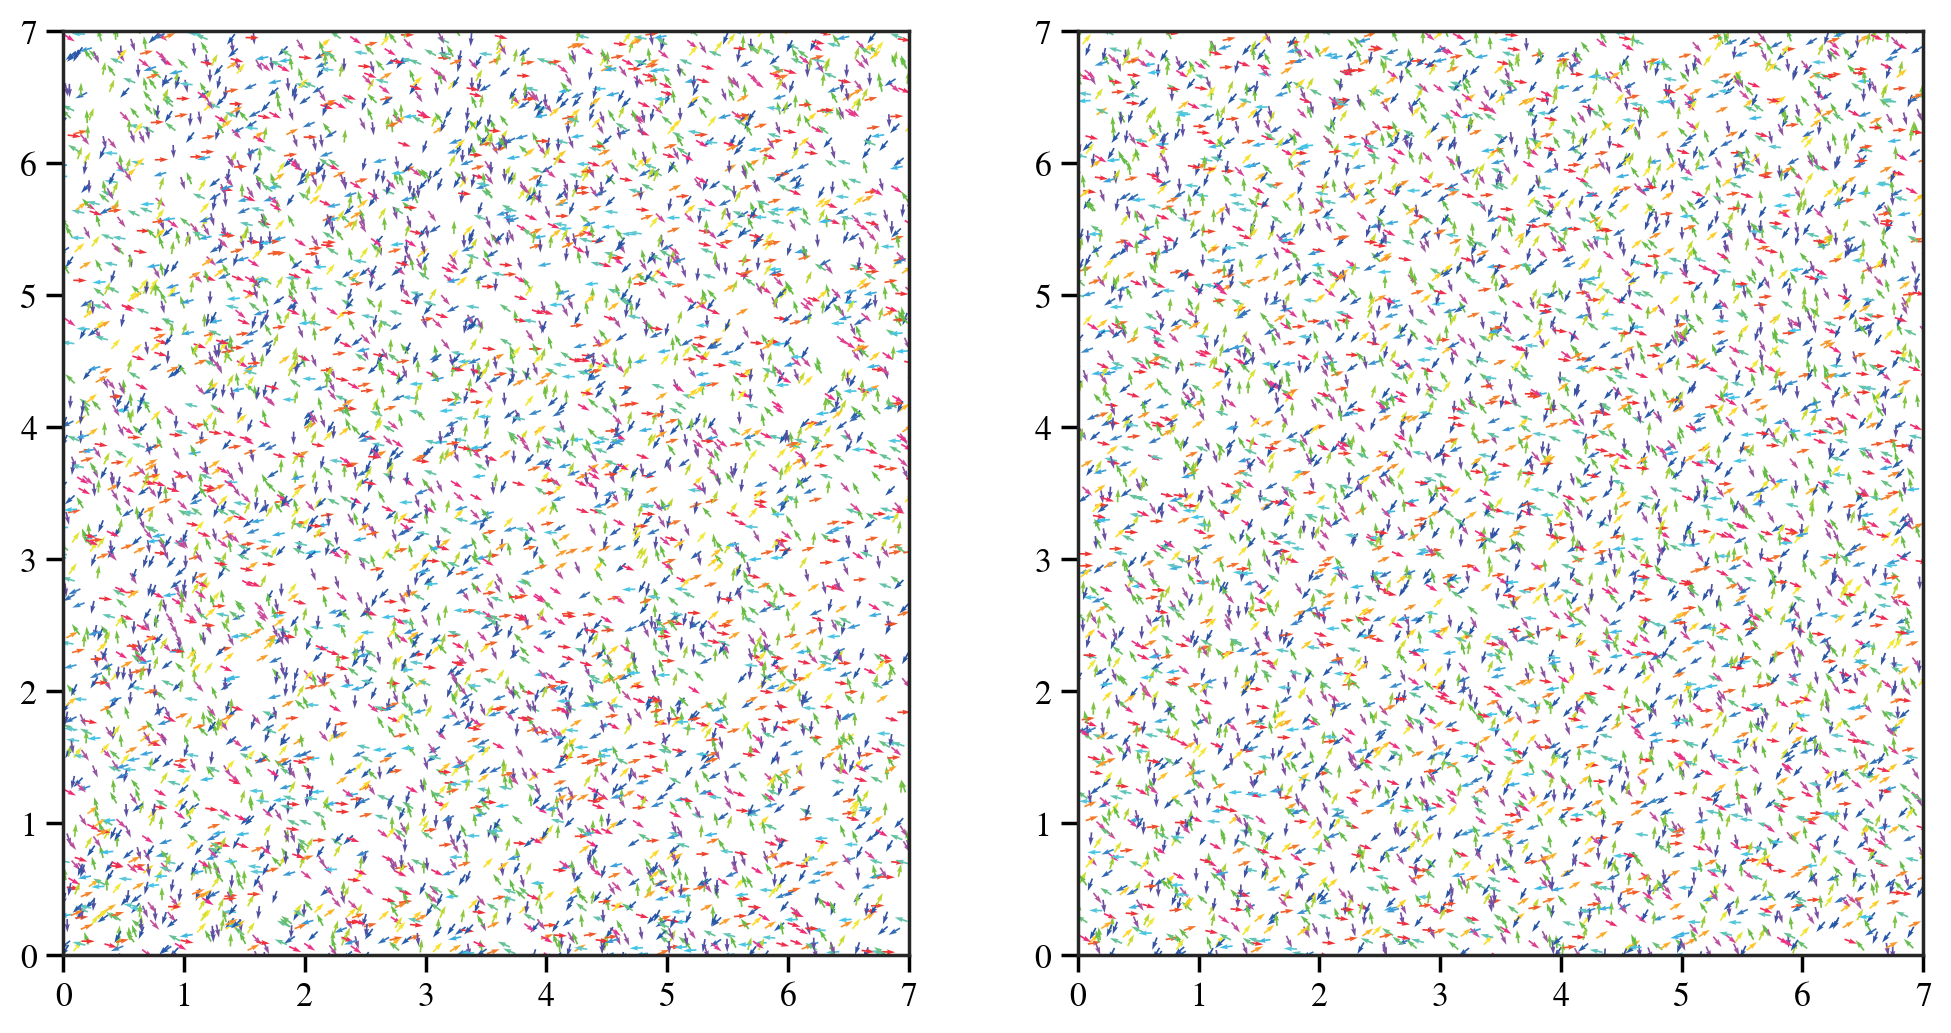

In [3]:
fig = plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
model.plot(ax=ax1)

ax2 = plt.subplot(1, 2, 2)
sa.plot_spatial(ax=ax2, index=541)

In [ ]:
@nb.njit
def calc_replative_distance(positions: np.ndarray, center: np.ndarray, boundaryLength: float):
    positionX, others = positions, center
    halfBoundaryLength = boundaryLength / 2

    subX = positionX - others
    deltaX = positionX - (
        others * (-halfBoundaryLength <= subX) * (subX <= halfBoundaryLength) + 
        (others - boundaryLength) * (subX < -halfBoundaryLength) + 
        (others + boundaryLength) * (subX > halfBoundaryLength)
    )
    distances = np.sqrt((deltaX**2).sum(axis=-1))
    return distances

@nb.njit
def calculate_density_variance_2d(positions: np.ndarray, R_values: np.ndarray, L: float, num_samples=1000):
    N = len(positions)
    rho = N / (L * L)
    
    variances = []
    poisson_var = []
    
    for R in R_values:
        counts = []
        
        for _ in range(num_samples):
            center = np.random.rand(2) * L

            dists = calc_replative_distance(positions, center, L)
            count = np.sum(dists <= R)
            counts.append(count)
        
        counts = np.array(counts)
        variance = np.var(counts)
        variances.append(variance)
        
        window_area = np.pi * R**2
        poisson_var.append(rho * window_area)
    
    return R_values, variances, poisson_var

R_min = 0.1
R_max = model.boundaryLength / 4
num_R = 50
R_values = np.linspace(R_min, R_max, num_R)

slope_list = []
for i in tqdm(range(0, sa.TNum, 1)):
    positionX, phaseTheta = sa.get_state(i)
    R_values, variances, poisson_var = calculate_density_variance_2d(
        positionX, R_values, num_samples=1000, L=model.boundaryLength
    )
    slope = np.polyfit(np.log(R_values[1:]), np.log(variances[1:]), 1)[0]
    slope_list.append(slope)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
phaseLags = [0.6 * np.pi]
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10 
strengthKs = np.linspace(1, 20, 19)
distanceD0s = np.linspace(0.1, 3, 19)  
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]
models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

lastStateSavePath = r"F:\MS_ExperimentData\lattice"
savePath = (
    f"{lastStateSavePath}/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)


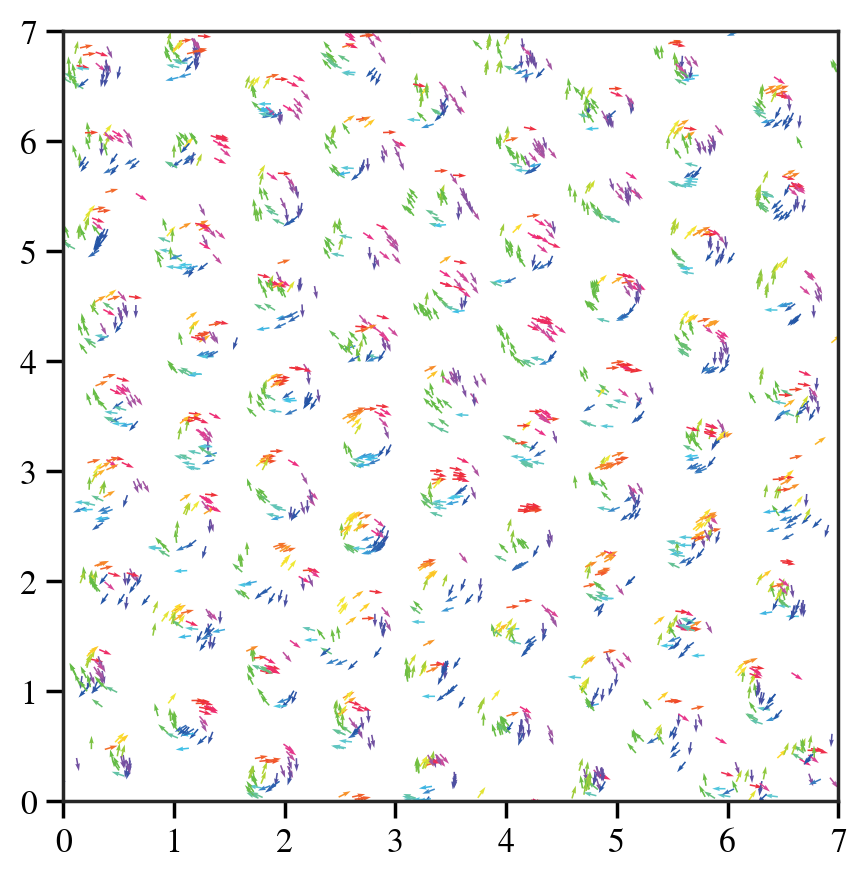

In [ ]:
sa = [sa for sa in sas if sa.model.strengthK == 20 and sa.model.distanceD0 == distanceD0s[3]][0]
sa.plot_spatial()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

@nb.njit
def calculate_Sk_continuous(positions, k_vec):
    N = len(positions)
    phases = np.exp(-1j * np.dot(positions, k_vec))
    sum_phase = np.sum(phases)
    return np.abs(sum_phase)**2 / N

@nb.njit(parallel=True)
def compute_S_radial_parallel(totalPositions_cont, k_values, k_vectors, num_angles):
    num_time_steps = len(totalPositions_cont)
    num_k_points = len(k_values)
    S_radial = np.zeros((num_k_points, num_time_steps))
    
    for t in nb.prange(num_time_steps):
        positions = totalPositions_cont[t]
        for i in range(num_k_points):
            k_mag = k_values[i]
            S_angle_avg = 0.0
            for j in range(len(k_vectors)):
                k_vec = k_mag * k_vectors[j]
                S_k = calculate_Sk_continuous(positions, k_vec)
                S_angle_avg += S_k
            S_radial[i, t] = S_angle_avg / num_angles
    return S_radial

# 参数设置
k_max = 10.0  # 最大k值
num_k_points = 100
num_angles = 72  # 角度采样数（越多越准确）

# 预计算k值和角度向量
k_values = np.linspace(0, k_max, num_k_points + 1)[1:]
angles = np.linspace(0, 2*np.pi, num_angles, endpoint=False)
k_vectors = np.ascontiguousarray(np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in angles]))

totalPositions = sa.totalPositionX
    # 确保所有数组都是连续的
totalPositions_cont = [np.ascontiguousarray(pos[::]) for pos in totalPositions]

# 使用Numba加速的计算函数
S_radial = compute_S_radial_parallel(totalPositions_cont, k_values, k_vectors, num_angles)

In [119]:
@nb.njit
def calculate_Sq_continuous(pos: np.ndarray, q_vec: np.ndarray, N: int):
    exp = np.exp(1j * np.dot(pos, q_vec))
    # return np.abs(np.sum(exp)) / N
    return np.abs(np.sum(exp)**2 / N)

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=0.6 * np.pi,
        speedV=3,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=0, deltaOmega=0, 
        agentsNum=5000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for (strengthK, distanceD0) in [[20, 0.25], [20, 0.1], [1, 3], [1, 0.1]]
]
positions = dict()
for model in models:
    sa = StateAnalysis(model)
    # positions[(model.strengthK, model.distanceD0)] = sa.totalPositionX[-1]
    positions[(model.strengthK, model.distanceD0)] = sa.totalPositionX[-500:][::100]
positions[(0, 0)] = np.array([model.positionX])

In [120]:
x = np.arange(1, 80) * 2 * np.pi / model.boundaryLength
X, Y = np.meshgrid(x, x)
qVecs = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors
q = np.linalg.norm(qVecs, axis=1)
qVecs = qVecs[np.argsort(q)]
q = np.sort(q)

Sqs_dict = dict()
for params, subPositions in tqdm(positions.items()):
    
    Sqs = []
    qs = []
    # position, _ = sa.get_state(-1)
    # position = model.positionX

    for position in tqdm(subPositions):
        for q_vec in qVecs:    
            Sq = calculate_Sq_continuous(position, q_vec, len(position))
            qs.append(np.linalg.norm(q_vec))
            Sqs.append(Sq)

    Sqs_dict[params] = (qs, np.array(Sqs))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
with open("Sqs_dict.pkl", "wb") as f:
    pickle.dump(Sqs_dict, f)

  0%|          | 0/5 [00:00<?, ?it/s]

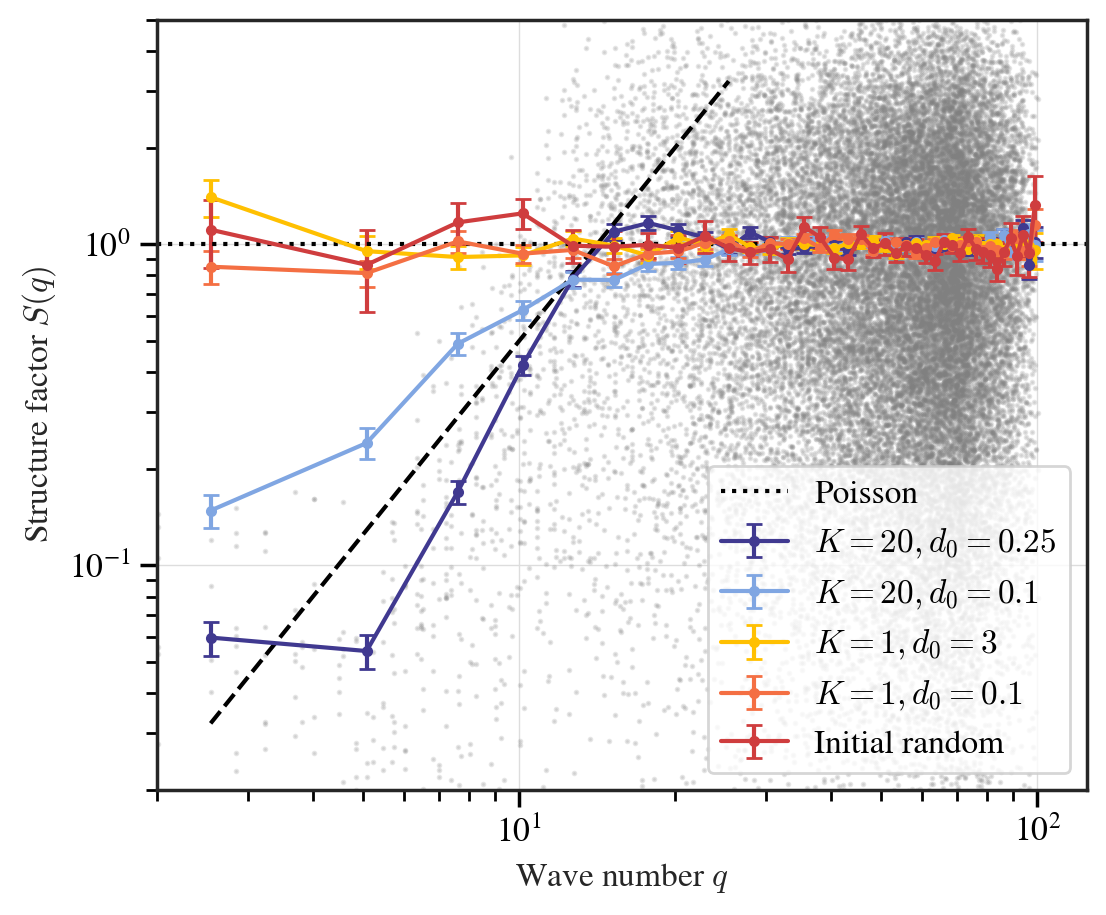

In [176]:
colors = ["#403990", "#80A6E2", "#FFC001", "#F46F43", "#CF3D3E"]
for params, (qs, Sqs) in tqdm(Sqs_dict.items()):
    qs, Sqs = np.array(qs), np.array(Sqs)
    if params == (20, 0.25):
        plt.plot(qs, Sqs, marker='o', markersize=1, ls="", color="gray", alpha=0.2)
    
    q_bins = np.linspace(qs.min(), qs.max(), 40)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))
    if params == (0, 0):
        label = "Initial random"
    else:
        label = rf"$K={params[0]},d_0={params[1]}$"
    plt.errorbar(
        0.5 * (q_bins[:-1] + q_bins[1:]), Sqs_binned[:, 0], yerr=Sqs_binned[:, 1],
        fmt='o-', markersize=3, capsize=3, label=label, 
        color=colors.pop(0)
    )

q_values = 0.5 * (q_bins[:-1] + q_bins[1:])[:10]
plt.plot(q_values, np.array(q_values) ** 2 * 0.005, '--', color="black", markersize=2, linewidth=1.5)

plt.axhline(1, color='black', linestyle=':', label="Poisson")
plt.legend(loc="lower right", fontsize=12)
plt.xlabel('Wave number $q$', fontsize=12)
plt.ylabel('Structure factor $S(q)$', fontsize=12)
plt.semilogx()
plt.semilogy()
plt.xlim(2, None)
plt.ylim(0.02, 5)
plt.grid()

In [177]:
import numpy as np
import matplotlib.pyplot as plt

# 第 1 步：生成泊松随机点
system_size = 7
num_particles = 5000

l_values = np.linspace(system_size / 50, system_size / 2, 20)  # 窗口大小 l
num_samples = 5000  # 每个l的随机采样次数 M

rho_0 = num_particles / (system_size**2)

variance_rho_dict = dict()

for params, subPositions in tqdm(positions.items()):
    points = subPositions[-1]
    
    mean_density = []
    variance_rho = []

    for l in l_values:
        n_in_window = []
        
        for _ in range(num_samples):
            low_x = np.random.rand() * (system_size - l)
            low_y = np.random.rand() * (system_size - l)
            high_x = low_x + l
            high_y = low_y + l
            
            cond_x = (points[:, 0] >= low_x) & (points[:, 0] <= high_x)
            cond_y = (points[:, 1] >= low_y) & (points[:, 1] <= high_y)
            count = np.sum(cond_x & cond_y)
            
            n_in_window.append(count)
        
        n_in_window = np.array(n_in_window)
        
        variance_n = np.var(n_in_window)
        
        variance_rho.append(variance_n / (l**4))  # ⟨δρ²⟩ = ⟨δn²⟩ / l^4

    variance_rho_dict[params] = (l_values, np.array(variance_rho))

  0%|          | 0/5 [00:00<?, ?it/s]

In [178]:
with open("variance_rho_dict.pkl", "wb") as f:
    pickle.dump(variance_rho_dict, f)

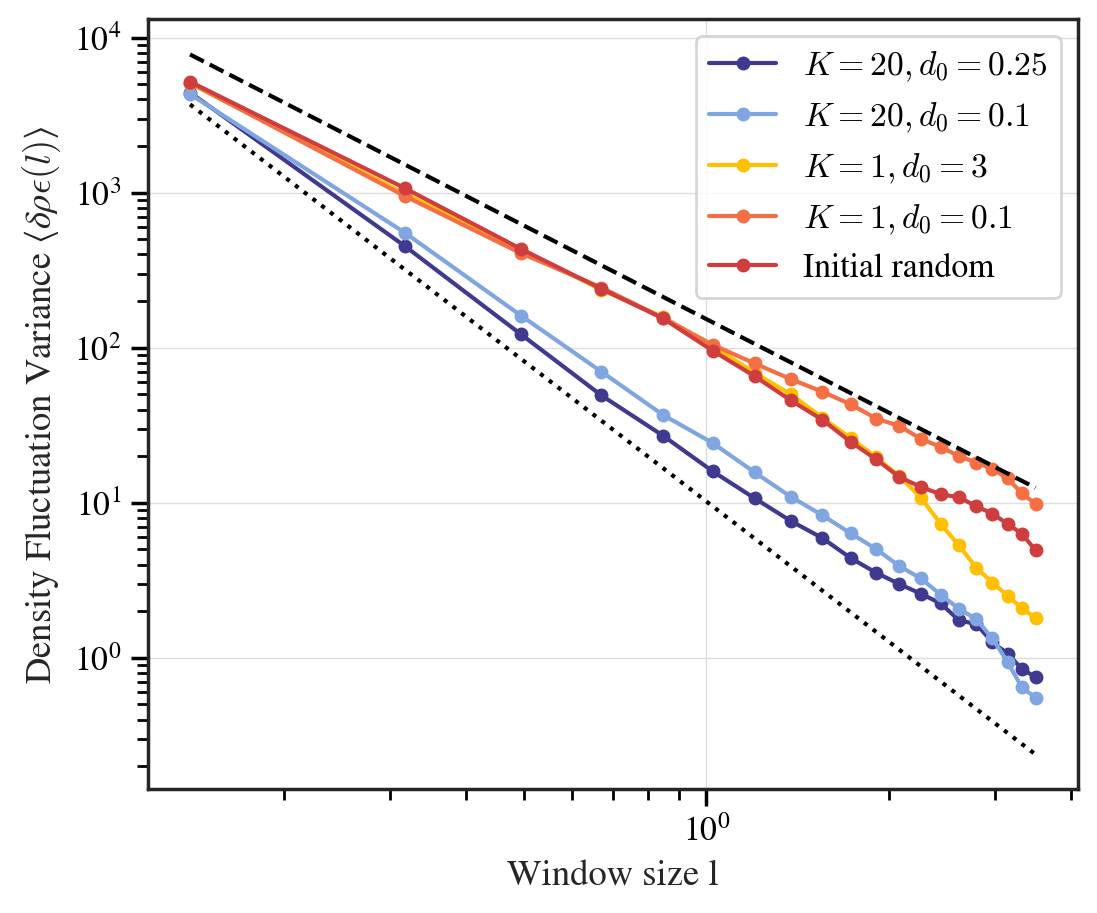

In [188]:
colors = ["#403990", "#80A6E2", "#FFC001", "#F46F43", "#CF3D3E"]

for params, (l_values, variance_rho) in variance_rho_dict.items():
    if params == (0, 0):
        label = "Initial random"
    else:
        label = rf"$K={params[0]},d_0={params[1]}$"
    plt.loglog(l_values, variance_rho, 'o-', label=label, color=colors.pop(0), markersize=4)

plt.loglog(l_values, rho_0 / (l_values**2) * 1.5, '--', color="black")
plt.loglog(l_values, rho_0 / (l_values**3) / 10, ':', color="black")
# 理论线 ⟨δρ²(𝑙)⟩ = ρ₀ / l²

plt.xlabel('Window size l')
plt.ylabel('Density Fluctuation Variance ⟨$δρ²(l)$⟩')
plt.legend()
plt.grid(True)
plt.show()